In [36]:
# Import library standar dan PySpark
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark Core
from pyspark.sql import SparkSession
# Tambahkan fungsi round untuk visualisasi
from pyspark.sql.functions import col, when, lit, count, isnull, sum as spark_sum, round
from pyspark.sql.types import DoubleType, IntegerType, StringType

# Spark MLlib Tools
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Inisialisasi Spark Session
spark = SparkSession.builder.appName("BigDataYelpRatingClassification").config("spark.driver.memory", "3g").config("spark.executor.memory", "3g").getOrCreate()

# file path
file_path = "file:///home/salwa/Downloads/yelp_database.csv" 
start_time = time.time()

In [37]:
print("MEMUAT DATASET & INITIAL DATA TRANSFORMATION (ETL)...")

# DAFTAR KOLOM AKTUAL DARI YELP DATASET
NUMERIC_COLS_FOR_FEATURE = ['NumberReview'] 
# KOREKSI: Hanya gunakan kolom kategorikal dengan data yang cukup
CATEGORICAL_COLS_FOR_FEATURE = ['City', 'State', 'Category'] 
TARGET_COL_SOURCE = 'Rating'

# Daftar semua kolom yang akan dicek kualitasnya
ALL_COLS_FOR_CHECK = [
    'Time_GMT', 'Phone', 'Organization', 'OLF', # OLF tetap di load, tapi tidak dijadikan feature
    'Rating', 'NumberReview', 'Category', 
    'Country', 'CountryCode', 'State', 'City', 
    'Street', 'Building'
]
LABEL_COL = 'IS_HIGH_RATING' 

try:
    df_spark = spark.read.csv(file_path, header=True, sep=',', inferSchema=True)
    
    # 1. Pilih semua kolom yang akan dicek kualitasnya
    df_spark = df_spark.select(*ALL_COLS_FOR_CHECK)

    # 2. Pembersihan & Konversi Tipe Data
    for c in [TARGET_COL_SOURCE] + NUMERIC_COLS_FOR_FEATURE:
        df_spark = df_spark.withColumn(c, col(c).cast(DoubleType()))
    for c in list(set(ALL_COLS_FOR_CHECK) - set(NUMERIC_COLS_FOR_FEATURE) - set([TARGET_COL_SOURCE])):
        df_spark = df_spark.withColumn(c, col(c).cast(StringType()))
        
    # 3. FEATURE ENGINEERING: Membuat Kolom Target Biner
    RATING_THRESHOLD = 4.0
    df_spark = df_spark.withColumn(
        LABEL_COL,
        when(col(TARGET_COL_SOURCE) > RATING_THRESHOLD, lit(1)).otherwise(lit(0))
    ).withColumn(LABEL_COL, col(LABEL_COL).cast(IntegerType()))

    NUMERIC_COLS_RAW = NUMERIC_COLS_FOR_FEATURE 
    CATEGORICAL_COLS_RAW = CATEGORICAL_COLS_FOR_FEATURE

    print(f"Dataset berhasil dimuat. Total baris: {df_spark.count()}")

except Exception as e:
    print("ERROR: Gagal memuat dataset penuh.")
    raise

MEMUAT DATASET & INITIAL DATA TRANSFORMATION (ETL)...


[Stage 355:============================>                            (1 + 1) / 2]

Dataset berhasil dimuat. Total baris: 1000000


In [38]:
print("DATA CLEANING: KUALITAS DATA AWAL & DUPLIKASI")

# Cek Duplikas
total_rows = df_spark.count()
distinct_rows = df_spark.distinct().count()
duplicate_count = total_rows - distinct_rows

print(f"   - Total Baris: {total_rows}")
print(f"   - Total Baris Unik: {distinct_rows}")
print(f"   - Jumlah Baris Duplikat: {duplicate_count}")

if duplicate_count > 0:
    print(" Duplikasi terdeteksi. Data duplikat akan dihilangkan...")
    df_spark = df_spark.dropDuplicates() # Hapus duplikasi untuk pembersihan
    print(f"-> Baris setelah penghapusan duplikasi: {df_spark.count()}")
else:
    print("Tidak ditemukan Duplikasi.")


# Cek Missing Values Awal (Meliputi semua kolom yang dimuat)
print("\nMissing Values (NaN/NULL) per Kolom (Semua Kolom):")
cols_to_check_mv = ALL_COLS_FOR_CHECK # Menggunakan daftar kolom yang lengkap
missing_df = df_spark.select([
    spark_sum(when(isnull(c) | (col(c) == '') | (col(c).cast('string') == 'NaN'), 1).otherwise(0)).alias(c)
    for c in cols_to_check_mv
]).collect()[0].asDict()

# Hanya tampilkan kolom yang memiliki missing value dan urutkan
missing_values_summary = {k: v for k, v in missing_df.items() if v > 0}
if missing_values_summary:
    for k, v in sorted(missing_values_summary.items(), key=lambda item: item[1], reverse=True):
        print(f"     -> {k} : {v} (persentase: {v/df_spark.count()*100:.2f}%)")
else:
    print("Tidak ditemukan Missing Values pada fitur utama.")

DATA CLEANING: KUALITAS DATA AWAL & DUPLIKASI


   - Total Baris: 1000000
   - Total Baris Unik: 994474
   - Jumlah Baris Duplikat: 5526
 Duplikasi terdeteksi. Data duplikat akan dihilangkan...


-> Baris setelah penghapusan duplikasi: 994474

Missing Values (NaN/NULL) per Kolom (Semua Kolom):


     -> OLF : 956486 (persentase: 96.18%)


     -> Street : 158414 (persentase: 15.93%)


     -> Building : 156753 (persentase: 15.76%)


     -> State : 1053 (persentase: 0.11%)


     -> Organization : 467 (persentase: 0.05%)


[Stage 411:>                                                        (0 + 2) / 2]

     -> City : 467 (persentase: 0.05%)


In [39]:
# Pembagian Data (Hanya menggunakan fitur terpilih
# Kita hanya menggunakan fitur yang untuk modeling
numeric_cols = NUMERIC_COLS_RAW
categorical_cols = CATEGORICAL_COLS_RAW

df_spark_features = df_spark.select(numeric_cols + categorical_cols + [LABEL_COL])
train_df, test_df = df_spark_features.randomSplit([0.8, 0.2], seed=42)

print(f"Ukuran data latih (train_df): {train_df.count()} baris")
print(f"  Ukuran data uji (test_df): {test_df.count()} baris")

Ukuran data latih (train_df): 795435 baris


[Stage 423:>                                                        (0 + 2) / 2]

  Ukuran data uji (test_df): 199039 baris


In [40]:
print("FEATURE ENGINEERING: IMPUTASI")

# Daftar kolom Imputed
numeric_imputed = [c + '_imputed' for c in numeric_cols]
# Kolom kategorikal tidak memerlukan Imputer terpisah, cukup dihandle oleh StringIndexer

# 4.1 Definisi Imputer Numerik
imputer_numeric = Imputer(
    inputCols=numeric_cols, 
    outputCols=numeric_imputed, 
    strategy='median' 
)

# LANGKAH 1: IMPUTASI NUMERIK (Median)
print("Melakukan Imputasi Numerik (Median)...")
imputer_model_num = imputer_numeric.fit(train_df)
train_df = imputer_model_num.transform(train_df) 
test_df = imputer_model_num.transform(test_df) 

# HAPUS: Kolom numerik asli dihilangkan. 
train_df = train_df.drop(*numeric_cols)
test_df = test_df.drop(*numeric_cols)

# LANGKAH 2: IMPUTASI KATEGORICAL (TIDAK DILAKUKAN)
# Missing values pada kolom kategorikal akan ditangani oleh StringIndexer

# cek Kualitas Data Akhir (Verifikasi Imputasi Numerik)
print("Cek Missing Values (Setelah Imputasi Numerik):")
# Cek pada kolom numerik yang telah diimputasi
imputed_check_cols = numeric_imputed 
missing_after_impute = train_df.select([
    spark_sum(when(isnull(c), 1).otherwise(0)).alias(c)
    for c in imputed_check_cols
]).collect()[0].asDict()

total_missing_after = sum(missing_after_impute.values())

if total_missing_after == 0:
    print(f"Hasil Imputasi Numerik: Jumlah Missing Values = {total_missing_after}. BERHASIL.")
else:
    print(f"Hasil Imputasi Numerik: Terdapat {total_missing_after} Missing Values tersisa.")

FEATURE ENGINEERING: IMPUTASI
Melakukan Imputasi Numerik (Median)...


Cek Missing Values (Setelah Imputasi Numerik):


[Stage 434:>                                                        (0 + 2) / 2]

Hasil Imputasi Numerik: Jumlah Missing Values = 0. BERHASIL.


VISUALISASI DATA


   - Data sampling PySpark ke Pandas: 199168 baris.


/tmp/ipykernel_12082/1245768626.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_12082/1245768626.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Rating Rendah (0)', 'Rating Tinggi (1)'])
/tmp/ipykernel_12082/1245768626.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_12082/1245768626.py:32: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(


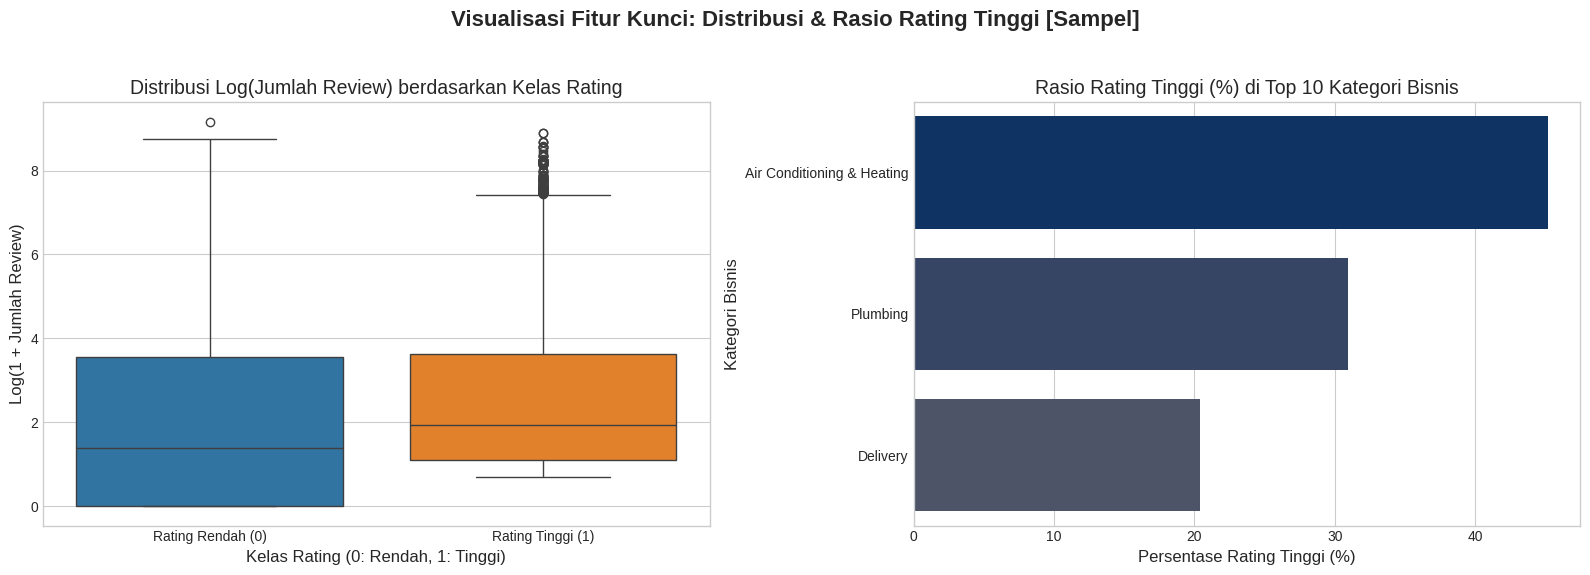

In [42]:
print("VISUALISASI DATA")

# Ambil sampel PySpark DataFrame dan konversi ke Pandas 
sample_size = 0.20
cols_for_sample = [TARGET_COL_SOURCE] + NUMERIC_COLS_FOR_FEATURE + CATEGORICAL_COLS_FOR_FEATURE + [LABEL_COL]
df_sample = df_spark.select(*cols_for_sample).sample(False, sample_size, seed=42).toPandas()
print(f"   - Data sampling PySpark ke Pandas: {len(df_sample)} baris.")

# PLOT 1 & 2: Box Plot & Ratio Bar Chart dalam satu Figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Visualisasi Fitur Kunci: Distribusi & Rasio Rating Tinggi [Sampel]', fontsize=16, fontweight='bold')

# 1.1 Box Plot Log(NumberReview) vs. Target Class
df_sample['Log_NumberReview'] = np.log1p(df_sample['NumberReview']) 
sns.boxplot(
    x=LABEL_COL, 
    y='Log_NumberReview', 
    data=df_sample, 
    palette=['#1f77b4', '#ff7f0e'],
    ax=axes[0]
)
axes[0].set_title('Distribusi Log(Jumlah Review) berdasarkan Kelas Rating', fontsize=14)
axes[0].set_xlabel('Kelas Rating (0: Rendah, 1: Tinggi)', fontsize=12)
axes[0].set_ylabel('Log(1 + Jumlah Review)', fontsize=12)
axes[0].set_xticklabels(['Rating Rendah (0)', 'Rating Tinggi (1)'])


# 1.2 DISTRIBUSI RASIO RATING TINGGI DI TOP 10 KATEGORI
top_10_categories = df_sample['Category'].value_counts().index[:10]
high_rating_ratio = df_sample[df_sample['Category'].isin(top_10_categories)].groupby('Category')[LABEL_COL].mean().sort_values(ascending=False) * 100

sns.barplot(
    x=high_rating_ratio.values, 
    y=high_rating_ratio.index, 
    palette=sns.color_palette("cividis", n_colors=10),
    ax=axes[1]
)
axes[1].set_title('Rasio Rating Tinggi (%) di Top 10 Kategori Bisnis', fontsize=14)
axes[1].set_xlabel('Persentase Rating Tinggi (%)', fontsize=12)
axes[1].set_ylabel('Kategori Bisnis', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

del df_sample # Membebaskan memori driver

In [43]:
print("SPARK MLlib: PIPELINE & MODEL TRAINING")

categorical_cols_for_pipeline = categorical_cols # City, State, Category
numeric_cols_for_pipeline = numeric_imputed    # NumberReview_imputed

# Sisa Transformer (Encoding & Scaling)
# StringIndexer (handleInvalid='keep' otomatis menangani missing values)
indexers = [
    StringIndexer(inputCol=c, outputCol=c + '_indexed', handleInvalid='keep') 
    for c in categorical_cols_for_pipeline
]
encoders = [
    OneHotEncoder(inputCol=c + '_indexed', outputCol=c + '_encoded') 
    for c in categorical_cols_for_pipeline
]
categorical_encoded = [c + '_encoded' for c in categorical_cols_for_pipeline]

feature_cols_raw = numeric_cols_for_pipeline + categorical_encoded
assembler = VectorAssembler(inputCols=feature_cols_raw, outputCol="features_vector")

# Normalisasi (StandardScaler)
scaler = StandardScaler(inputCol="features_vector", outputCol="features_scaled", withStd=True, withMean=False) 

# Definisi Model Klasifikasi 
lr = LogisticRegression(featuresCol="features_scaled", labelCol=LABEL_COL, maxIter=10, regParam=0.01) 

# Build Final Pipeline
pipeline_stages_final = (indexers + encoders + [assembler, scaler, lr])
pipeline = Pipeline(stages=pipeline_stages_final)

# Melatih Model
print("Mulai Melatih Model (Pipeline Fit) pada data latih...")
model_spark = pipeline.fit(train_df)

# Prediksi
predictions = model_spark.transform(test_df)
print("Prediksi pada data uji selesai.")

SPARK MLlib: PIPELINE & MODEL TRAINING
Mulai Melatih Model (Pipeline Fit) pada data latih...


25/11/25 18:38:03 WARN DAGScheduler: Broadcasting large task binary with size 1479.1 KiB
25/11/25 18:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1452.9 KiB
25/11/25 18:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1608.8 KiB
25/11/25 18:39:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/25 18:39:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/11/25 18:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1609.5 KiB
25/11/25 18:39:21 WARN DAGScheduler: Broadcasting large task binary with size 1609.5 KiB
25/11/25 18:39:22 WARN DAGScheduler: Broadcasting large task binary with size 1609.5 KiB
25/11/25 18:39:22 WARN DAGScheduler: Broadcasting large task binary with size 1609.5 KiB
25/11/25 18:39:22 WARN DAGScheduler: Broadcasting large task binary with size 1609.5 KiB
25/11/25 18:39:23 WARN DAGScheduler: Broadcasting large task binary wit

Prediksi pada data uji selesai.


OUTPUT ANALISIS: EVALUASI MODEL SPARK MLlib


25/11/25 18:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1707.9 KiB
                                                                                

akurasi Model Spark MLlib: 0.7545


25/11/25 18:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1706.7 KiB
25/11/25 18:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1665.9 KiB
25/11/25 18:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1665.3 KiB
25/11/25 18:52:10 WARN DAGScheduler: Broadcasting large task binary with size 1706.7 KiB
25/11/25 18:52:14 WARN DAGScheduler: Broadcasting large task binary with size 1665.9 KiB
25/11/25 18:52:14 WARN DAGScheduler: Broadcasting large task binary with size 1665.3 KiB
25/11/25 18:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1706.7 KiB
25/11/25 18:52:24 WARN DAGScheduler: Broadcasting large task binary with size 1665.9 KiB
25/11/25 18:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1665.3 KiB
25/11/25 18:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1706.7 KiB
25/11/25 18:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1665.9 KiB
25/11/25 18:52:35 WAR

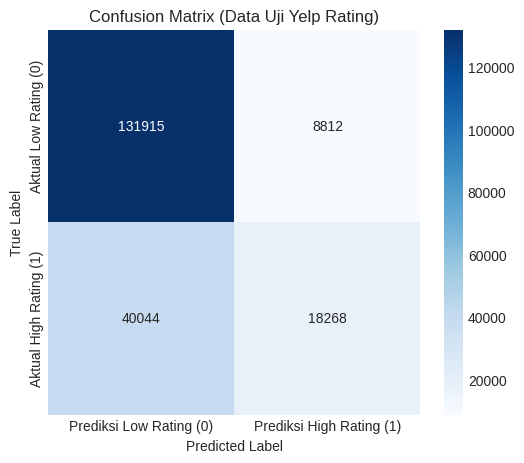

SEMUA TUGAS SELESAI MENGGUNAKAN PYSPARK/SPARK MLlib
Total Waktu Eksekusi: 1287.41 detik.


In [48]:
print("OUTPUT ANALISIS: EVALUASI MODEL SPARK MLlib")

# Akurasi Model
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol=LABEL_COL, 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator_accuracy.evaluate(predictions)
print(f"akurasi Model Spark MLlib: {accuracy:.4f}")

# Confusion Matrix
# Membuat pivot table
pivot_table = predictions.groupBy(LABEL_COL).pivot("prediction", [0.0, 1.0]).agg(count("prediction")).fillna(0)

try:
    # Menggunakan tanda backtick (`) untuk merujuk kolom '0.0' dan '1.0'
    TN = pivot_table.filter(col(LABEL_COL) == 0).select(col('`0.0`')).collect()[0][0]
    FP = pivot_table.filter(col(LABEL_COL) == 0).select(col('`1.0`')).collect()[0][0]
    FN = pivot_table.filter(col(LABEL_COL) == 1).select(col('`0.0`')).collect()[0][0]
    TP = pivot_table.filter(col(LABEL_COL) == 1).select(col('`1.0`')).collect()[0][0]
except IndexError:
    print("\n[PERINGATAN]: Confusion Matrix tidak lengkap karena salah satu kelas target (0 atau 1) mungkin hilang dari data uji.")
    TN, FP, FN, TP = 0, 0, 0, 0 

# Visualisasi Confusion Matrix
cm_matrix = pd.DataFrame([[TN, FP], [FN, TP]], index=['Aktual Low Rating (0)', 'Aktual High Rating (1)'], columns=['Prediksi Low Rating (0)', 'Prediksi High Rating (1)'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Data Uji Yelp Rating)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

total_duration = time.time() - start_time
print(f"SEMUA TUGAS SELESAI MENGGUNAKAN PYSPARK/SPARK MLlib")
print(f"Total Waktu Eksekusi: {total_duration:.2f} detik.")